In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
os.sys.path
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
def draw_matches(img1, keypoints1, img2, keypoints2, matches):
    r, c = img1.shape[:2]
    r1, c1 = img2.shape[:2]

  # Create a blank image with the size of the first image + second image
    output_img = np.zeros((max([r, r1]), c+c1, 3), dtype='uint8')
    output_img[:r, :c, :] = np.dstack([img1, img1, img1])
    output_img[:r1, c:c+c1, :] = np.dstack([img2, img2, img2])
    for match in matches:
        img1_idx = match.queryIdx
        img2_idx = match.trainIdx
        (x1, y1) = keypoints1[img1_idx].pt
        (x2, y2) = keypoints2[img2_idx].pt

    # Draw circles on the keypoints
        cv2.circle(output_img, (int(x1),int(y1)), 4, (0, 255, 255), 1)
        cv2.circle(output_img, (int(x2)+c,int(y2)), 4, (0, 255, 255), 1)

    # Connect the same keypoints
        cv2.line(output_img, (int(x1),int(y1)), (int(x2)+c,int(y2)), (0, 255, 255), 1)
    
    return output_img

In [4]:
def warpImages(img1, img2, H):
    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]

    list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

    # When we have established a homography we need to warp perspective Change field of view
    list_of_points_2 = cv2.perspectiveTransform(temp_points, H)
    list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  
    translation_dist = [-x_min,-y_min]
  
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

    output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
    output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

    return output_img

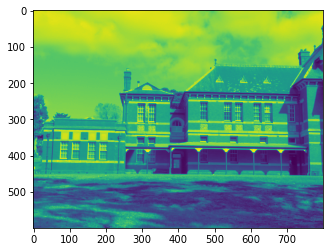

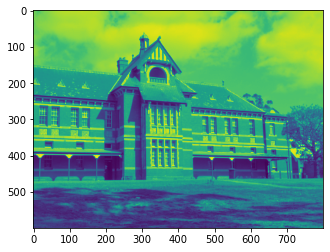

In [5]:
image1 = cv2.imread('dataset/Set1/image1.jpg')
img1_gray = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
image2= cv2.imread('dataset/Set1/image2.jpg')
img2_gray = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)

plt.imshow(img1_gray)
plt.show()

plt.imshow(img2_gray)
plt.show()

In [6]:
# Create our ORB detector and detect keypoints and descriptors
orb = cv2.ORB_create(nfeatures=2000)

# Find the key points and descriptors with ORB
keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

In [7]:
# Create a BFMatcher object to find all of the matching keypoints on two images
bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)

# Find matching points
matches = bf.knnMatch(descriptors1, descriptors2,k=2)
print(keypoints1[0].pt)
print(keypoints1[0].size)
print("Descriptor of the first keypoint: ")
print(descriptors1[0])


(250.0, 248.0)
31.0
Descriptor of the first keypoint: 
[ 31  23  67 165 114  54 110 120  53 234  91 231 125 102 187 240  54 237
  23 239 165 144  61 238 182 109 170 128  47 247  35 213]


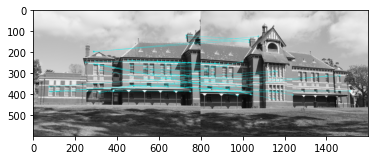

In [8]:
all_matches = []
for m, n in matches:
    all_matches.append(m)

img3 = draw_matches(img1_gray, keypoints1, img2_gray, keypoints2, all_matches[:30])
cv2.imwrite('Results/Set1/Set1_matches.jpg', img3)
plt.imshow(img3)

In [9]:
#good matches
good = []
for m, n in matches:
    if m.distance < 0.6 * n.distance:
        good.append(m)

In [10]:
cv2.drawKeypoints(image1, [keypoints1[m.queryIdx] for m in good], None, (255, 0, 255))
cv2.drawKeypoints(image2, [keypoints2[m.trainIdx] for m in good], None, (255, 0, 255))

array([[[231, 201, 182],
        [233, 203, 184],
        [232, 205, 184],
        ...,
        [243, 233, 216],
        [245, 232, 216],
        [244, 231, 215]],

       [[229, 208, 186],
        [231, 208, 186],
        [231, 207, 185],
        ...,
        [242, 232, 215],
        [245, 232, 218],
        [244, 231, 217]],

       [[231, 208, 186],
        [233, 209, 187],
        [231, 207, 183],
        ...,
        [244, 231, 217],
        [244, 231, 217],
        [245, 232, 218]],

       ...,

       [[ 33,  60,  56],
        [ 38,  63,  59],
        [ 28,  53,  49],
        ...,
        [ 96, 128, 147],
        [ 78, 110, 133],
        [ 67, 101, 125]],

       [[ 26,  57,  50],
        [ 31,  59,  53],
        [ 28,  51,  47],
        ...,
        [100, 122, 147],
        [100, 122, 147],
        [ 74,  94, 119]],

       [[ 24,  54,  49],
        [ 29,  56,  53],
        [ 29,  50,  48],
        ...,
        [104, 125, 152],
        [106, 127, 154],
        [110, 129, 156]]

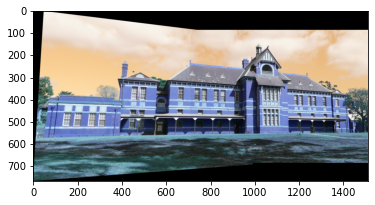

In [11]:
# Set minimum match condition
MIN_MATCH_COUNT = 10

if len(good) > MIN_MATCH_COUNT:
    # Convert keypoints to an argument for findHomography
    src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    # Establish a homography
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    
    result = warpImages(image2, image1, M)
    cv2.imwrite('Results/Set1/Set1_Panaroma.png',result)
    plt.imshow(result)